# Prototyping 1D EFGP 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from efgp1d import efgp1d, efgp1d_NUFFT, efgp1d_gradient_batched, compute_convolution_vector_vectorized
from efgp_1d_dense import efgp1d_dense
from efgp1d import Toeplitz1D, compute_convolution_vector_vectorized
from cg import ConjugateGradients, BatchConjugateGradients
from efgp1d import ToeplitzND, compute_convolution_vector_vectorized_dD, _cmplx

import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# Boring GP sampler

In [2]:


# --- Parameters ---
n = 100  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.3
true_variance = 2
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 50
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

# --- Define Mean and Covariance Functions (using PyTorch) ---
def mean_func_torch(x):
    """Mean function (returns zero vector)."""
    # Make sure output shape matches input batch shape if any
    return torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)

# Squared Exponential Kernel Function for d-dimensional inputs
def squared_exponential_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """
    Squared Exponential kernel using PyTorch.
    Calculates variance * exp(-0.5 * ||x1 - x2||^2 / length_scale^2)
    Handles multi-dimensional (n, d) inputs.
    """
    # Compute pairwise squared Euclidean distances
    # dist_sq = ||a - b||^2 = ||a||^2 - 2a^T b + ||b||^2
    sum_sq_x1 = torch.sum(x1**2, dim=1, keepdim=True)  # Shape (n, 1)
    sum_sq_x2 = torch.sum(x2**2, dim=1)                # Shape (m,)
    cross_term = torch.matmul(x1, x2.T)                # Shape (n, m)

    # sq_dist shape: (n, 1) + (m,) - 2 * (n, m) -> broadcasting -> (n, m)
    sq_dist = sum_sq_x1 + sum_sq_x2 - 2 * cross_term

    # Ensure squared distances are non-negative (due to potential floating point inaccuracies)
    sq_dist = torch.clamp(sq_dist, min=0.0)

    # Compute the Squared Exponential kernel
    cov = variance * torch.exp(-0.5 * sq_dist / length_scale**2)
    return cov

# --- Optimized Sampling Function ---
def sample_gp_fast(x, mean_func, cov_func, num_samples, length_scale, variance, noise_variance):
    """
    Samples efficiently from a d-dimensional Gaussian Process by pre-computing
    the Cholesky decomposition of the noisy covariance matrix.

    Parameters:
    x : torch.Tensor (n, d)
        Input points in d-dimensional space.
    mean_func : callable
        Mean function.
    cov_func : callable
        Covariance function (kernel).
    num_samples : int
        Number of samples to draw.
    length_scale : float
        Kernel length scale.
    variance : float
        Kernel variance.
    noise_variance : float
        Variance of the observation noise.

    Returns:
    torch.Tensor (n, num_samples)
        Samples from the GP at the input points x.
    """
    n_points = x.shape[0]
    mean = mean_func(x)  # Shape (n_points,)

    # 1. Compute Covariance Matrix K
    K = cov_func(x, x, length_scale=length_scale, variance=variance)  # (n_points, n_points)

    # 2. Add Noise Variance to Diagonal
    K_noisy = K + noise_variance * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # 3. Compute Cholesky Factor L (K_noisy = L L^T)
    try:
        L = torch.linalg.cholesky(K_noisy)  # (n_points, n_points), lower triangular
    except torch.linalg.LinAlgError as e:
        print(f"Cholesky decomposition failed: {e}")
        # Fallback with jitter
        jitter = 1e-6 * torch.eye(n_points, dtype=x.dtype, device=x.device)
        try:
            L = torch.linalg.cholesky(K_noisy + jitter)
            print("Cholesky succeeded after adding jitter.")
        except torch.linalg.LinAlgError as e2:
            print(f"Cholesky decomposition failed even with jitter: {e2}")
            raise RuntimeError("Could not compute Cholesky decomposition.") from e2

    # 4. Efficient Sampling
    # Draw standard normal samples Z ~ N(0, I)
    Z = torch.randn(n_points, num_samples, dtype=x.dtype, device=x.device)  # (n_points, num_samples)

    # Compute samples: Y = mean + L @ Z
    samples = mean.unsqueeze(1) + L @ Z  # (n_points, num_samples)

    return samples

# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    mean_func_torch,
    squared_exponential_kernel,
    num_samples=1,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 sample for n=100 points in 2 dimensions...
Generated sample of size 100.
Time taken: 0.0005 seconds


In [3]:
# save (x,y) to a torch file
# torch.save((x,y), f'gp_samples_{n}_{true_length_scale}_{true_variance}_{true_noise_variance}.pt')


In [4]:
# load (x,y) from a torch file
# x, y = torch.load(f'gp_samples_{n}_{true_length_scale}_{true_variance}_{true_noise_variance}.pt')

In [5]:
EPSILON = 1
sigmasq = torch.tensor(0.1, dtype=torch.float64)
kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([0.1]), variance=1)
init_kernel = kernel
# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))



$$(F \beta)_i  = \sum_{k=1}^M \exp(2\pi i h \langle j_k, x_ i\rangle)\beta_k$$
is a discrete fourier transform, but $\langle j_k, x_i\rangle$ are not uniformly spaced 


$$F\beta = \mathcal{F}(\beta) \in \mathbb C ^N,$$
with spacing given by 
$2\pi h (x)$

$$\frac{\partial \mathcal L}{\partial \theta} = \frac{1}{2M} \sum_{k=1}^M z_k^T((K + \sigma^2I)^{-1} \frac{\partial (K + \sigma^2 I)}{\partial \theta}) z_k - \frac{1}{2}y^T (K +\sigma^2 I)^{-1}\frac{\partial (K + \sigma^2 I)}{\partial \theta} (K+\sigma^2I)^{-1}y =I - II $$

# 3d testing..

In [6]:

def efgpnd_gradient_batched(
        x, y, sigmasq, kernel, eps, trace_samples, x0, x1,
        *, nufft_eps=1e-15, cg_tol = 1e-4, early_stopping = True, device=None, dtype=torch.float64):
    """
    Gradient of the 1‑D GP log‑marginal likelihood estimated with
    Hutchinson trace + CG, completely torch native.
    """
    # 0)  Book‑keeping ------------------------------------------------------
    device  = device or x.device
    # device = x.device
    rdtype = torch.float64
    cdtype = torch.complex128
    x       = x.to(device, dtype)
    y       = y.to(device, dtype)
    if x.ndim == 1:
        x = x.unsqueeze(-1)
    cmplx   = _cmplx(dtype)
    x0 = x.min(dim=0).values  
    x1 = x.max(dim=0).values  

    if x.ndim == 1:
        x = x.unsqueeze(-1)
    d = x.shape[1]
    domain_lengths = x1 - x0
    L = domain_lengths.max()
    N = x.shape[0]
    xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=eps, L=L, use_integral=False, l2scaled=False)
    # print(xis_1d.shape)
    grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
    xis = torch.stack(grids, dim=-1).view(-1, d) 
    ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d) # (mtot**d,1)
    Dprime  = (h**d * kernel.spectral_grad(xis)).to(cmplx)  # (M, 3)

    # 1)  NUFFT adjoint / forward helpers (modeord=False) -------------------
    OUT = (mtot,)*d
    
    nufft_eps = 1e-15
    def finufft1(vals):
        """
        Adjoint NUFFT: nonuniform→uniform.
        vals: (N,) complex
        returns: tensor of shape OUT, then flattened
        """
        arr = pff.finufft_type1(
            phi, vals.to(cdtype).contiguous(), OUT,
            eps=nufft_eps, isign=-1, modeord=False
        )
        return arr  # (mtot**d,)

    def finufft2(fk_flat):
        """
        Forward NUFFT: uniform→nonuniform.
        fk_flat: (mtot**d,) complex, in CMCL order
        returns: tensor of shape (N,)
        """

        if fk_flat.ndim == 1:
            fk_nd = fk_flat.reshape(OUT)
        else:
            OUT_trace = (fk_flat.shape[0],) + OUT
            fk_nd = fk_flat.reshape(OUT_trace).contiguous() # (T, mtot**d)
        # fk_nd = fk_flat
        return pff.finufft_type2(
            phi, fk_nd.to(cdtype), # phi is (d,N), fk_nd is (T, mtot**d)
            eps=nufft_eps, isign=+1, modeord=False
        )

    phi = (2 * math.pi * h * (x - 0.0)).to(dtype).T.contiguous()   # real (N,)
    fadj = lambda v: finufft1(v)    # NU → U
    fwd  = lambda fk: finufft2(fk)  # U  → NU

    # 2)  Toeplitz operator T (cached FFT) ----------------------------------
    m_conv       = (mtot - 1) // 2
    v_kernel     = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
    toeplitz   = ToeplitzND(v_kernel)               # cached once

    # 3)  Linear map A· = D F*F (D·) + σ² I -------------------------------
    def A_apply(beta):
        return ws * toeplitz(ws * beta) + sigmasq * beta

    # 4)  Solve A β = W F* y ---------------------------------------------
    rhs   = ws * fadj(y).reshape(-1)
    beta  = ConjugateGradients(A_apply, rhs,
                               torch.zeros_like(rhs),
                               tol=cg_tol, early_stopping=early_stopping).solve()
    alpha = (y - fwd(ws * beta)) / sigmasq

    # 5)  Term‑2  (α*D'α, α*α) --------------------------------------------
    fadj_alpha = fadj(alpha)
    term2 = torch.stack((
        torch.vdot(fadj_alpha.reshape(-1), Dprime[:, 0] * fadj_alpha.reshape(-1)),
        torch.vdot(fadj_alpha.reshape(-1), Dprime[:, 1] * fadj_alpha.reshape(-1)),
        torch.vdot(alpha,       alpha)
    ))

    # 6)  Monte‑Carlo trace (Term‑1) ---------------------------------------
    T  = trace_samples
    Z  = (2 * torch.randint(0, 2, (T, x.shape[0]), device=device,
                            dtype=dtype) - 1).to(cmplx)
    fadjZ = fadj(Z)

    B_blocks, R_blocks = [], []
    for i in range(3):
        # Dprime[:, i] * fadjZ.reshape(trace_samples,-1) should be shape (trace_samples, M)
        rhs_i = fwd(Dprime[:, i] * fadjZ.reshape(int(trace_samples),-1)) if i < 2 else Z
        R_blocks.append(rhs_i)
        B_blocks.append(ws * fadj(rhs_i).reshape(int(trace_samples),-1))

    B_all = torch.cat(B_blocks, 0)       # (3T, M)
    R_all = torch.cat(R_blocks, 0)       # (3T, N)

    def A_apply_batch(B):
        return ws * toeplitz(ws * B) + sigmasq * B

    Beta_all = BatchConjugateGradients(
        A_apply_batch, B_all, torch.zeros_like(B_all),
        tol=cg_tol, early_stopping=early_stopping).solve()

    Alpha_all = (R_all - fwd(ws * Beta_all)) / sigmasq
    A_chunks  = Alpha_all.chunk(3, 0)

    term1 = torch.stack([(Z * a).sum(1).mean() for a in A_chunks])

    # 7)  Gradient ----------------------------------------------------------
    grad = 0.5 * (term1 - term2)
    return grad.real  
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  
grad = efgpnd_gradient_batched(x, y, sigmasq, kernel, EPSILON, trace_samples=10, x0=x0, x1=x1)
print(grad)

tensor([-640.7329,  -44.1390,  -13.3458], dtype=torch.float64)


/Users/colecitrenbaum/Documents/GPs/gp-quadrature/cg.py:67: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4412.)
  r_norm = torch.conj(r.T) @ r


# direct inversion using the fourier approximation 
- very similar to auto grad

In [7]:

def compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON):
    # sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
    # kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

    # Flatten data to 1D.
    # if x is 1d unsqueeze
    if len(x.shape) == 1:
        x = x.unsqueeze(-1)
    # x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    # y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    # x_new = torch.linspace(0, 5, 1000, dtype=torch.float64)
    d = x.shape[1]
    
    x0 = x.min(dim=0).values  
    x1 = x.max(dim=0).values  

    domain_lengths = x1 - x0
    L = domain_lengths.max()
    N = x.shape[0]
    # print(EPSILON)
    xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)
    # print(xis_1d.shape)
    grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
    xis = torch.stack(grids, dim=-1).view(-1, d) 
    ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d) # (mtot**d,1)

    D = torch.diag(ws).to(dtype=torch.complex128)         # D: (M, M)

    # Form design features F (N x M): F[n,m] = exp(2pi i * xis[m] * x[n])
    # F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)
    F = torch.exp(1j * 2 * torch.pi * (x @ xis.T))

    # Compute approximate kernel: K = F * D^2 * F^*.
    D2 = D @ D  # This is just diag(ws^2)
    K = F @ D2 @ F.conj().transpose(-2, -1)  # shape: (N, N)
    C = K + sigmasq * torch.eye(N, dtype=torch.complex128)  # add noise term

    # Directly invert C and compute alpha.
    C_inv = torch.linalg.inv(C)
    alpha = C_inv @ y.to(dtype=torch.complex128)  # shape: (N,)

    # Compute derivative of the kernel with respect to the kernel hyperparameters.
    # Let spectral_grad = kernel.spectral_grad(xis), shape: (M, n_params)
    spectral_grad = kernel.spectral_grad(xis)  # shape: (M, n_params)
    # Then dK/dtheta for each kernel hyperparameter i is approximated as:
    # dK/dtheta_i = F * diag( h * spectral_grad(:, i) ) * F^*
    dK_dtheta_list = []
    n_params = spectral_grad.shape[1]
    for i in range(n_params):
        dK_i = F @ torch.diag((h**d * spectral_grad[:, i]).to(dtype=torch.complex128)) @ F.conj().transpose(-2, -1)
        dK_dtheta_list.append(dK_i)
    # The derivative with respect to the noise parameter is simply the identity.
    dK_dtheta_list.append(torch.eye(N, dtype=torch.complex128))
    n_total = n_params + 1

    # Compute gradient for each hyperparameter using:
    # grad = 0.5 * [trace(C_inv * dK/dtheta) - alpha^H * (dK/dtheta) * alpha]
    grad = torch.zeros(n_total, dtype=torch.complex128)
    for i in range(n_total):
        if i < n_params:
            term1 = torch.trace(C_inv @ dK_dtheta_list[i])
            term2 = (alpha.conj().unsqueeze(0) @ (dK_dtheta_list[i] @ alpha.unsqueeze(1))).squeeze()
        else:  # noise derivative: dC/d(sigmasq) = I
            term1 = torch.trace(C_inv)
            term2 = (alpha.conj().unsqueeze(0) @ alpha.unsqueeze(1)).squeeze()
        grad[i] = 0.5 * (term1 - term2)
        # print('term1:' ,term1.real)
        # print('term2:', term2.real) 

    # Print the gradients (real parts)
    # print("(Truncated) Direct inversion gradient:")
    # print(f"  dNLL/d(lengthscale) = {grad[0].real.item():.6f}")
    # if n_params > 1:
    #     print(f"  dNLL/d(variance)    = {grad[1].real.item():.6f}")
    # print(f"  dNLL/d(noise)       = {grad[-1].real.item():.6f}")
    true_grad = grad.clone()
    # print("term 1: ", term1.real, "term 2: ", term2.real)
    return true_grad.real
# Time the gradient computation
import time
start_time = time.time()

true_grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)
print(true_grad)
end_time = time.time()
print(f"Time taken for gradient computation: {end_time - start_time:.2f} seconds")


tensor([-593.1919,  -44.6589,   -8.1473], dtype=torch.float64)
Time taken for gradient computation: 0.03 seconds


# auto diff, full kernel, no approximations

In [8]:
# 3. Define the squared-exponential kernel.
def squared_exponential_kernel(x1, x2, lengthscale, variance):
    # Ensure inputs are 2D
    if x1.dim() == 1:
        x1 = x1.unsqueeze(1)
    if x2.dim() == 1:
        x2 = x2.unsqueeze(1)
    # Compute pairwise squared Euclidean distances.
    diff = x1.unsqueeze(1) - x2.unsqueeze(0)   # shape: (n1, n2, d)
    dist_sq = (diff ** 2).sum(dim=2)             # shape: (n1, n2)
    K = variance * torch.exp(-0.5 * dist_sq / (lengthscale ** 2))
    return K

# -------------------------
# 4. Define the negative log marginal likelihood (NLL)
def negative_log_marginal_likelihood(x, y, lengthscale, variance, noise):
    if x.dim() == 1:
        x = x.unsqueeze(1)
    if y.dim() == 1:
        y = y.unsqueeze(1)
    n = x.shape[0]
    # Compute kernel matrix K(X,X) and add noise on the diagonal.
    K = squared_exponential_kernel(x, x, lengthscale, variance) + noise * torch.eye(n, dtype=torch.float64)
    # Compute Cholesky factorization of K.
    L = torch.linalg.cholesky(K)
    # Solve for alpha = K^{-1} y using the Cholesky factors.
    alpha = torch.cholesky_solve(y, L)
    # Compute the log determinant of K via its Cholesky factor.
    logdetK = 2 * torch.sum(torch.log(torch.diag(L)))
    # NLL = 0.5 * y^T K^{-1} y + 0.5 * log|K| + 0.5*n*log(2π)
    nll = 0.5 * torch.matmul(y.T, alpha) + 0.5 * logdetK + 0.5 * n * math.log(2 * math.pi)
    return nll.squeeze()  # return a scalar
def compute_gradients_vanilla(x, y, sigmasq, kernel):
    if x.ndim == 1:
        x = x.unsqueeze(-1)
    if y.ndim == 1:
        y = y.unsqueeze(-1)


    # -------------------------
    # 2. Define hyperparameters as torch tensors with gradients.
    lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)
    variance    = torch.tensor(kernel.variance, dtype=torch.float64, requires_grad=True)
    noise       = sigmasq.clone().detach().requires_grad_(True)

    # -------------------------


    # -------------------------
    # 5. Compute the NLL and its gradients.
    nll = negative_log_marginal_likelihood(x, y, lengthscale, variance, noise)
    # print("Negative log marginal likelihood:", nll.item())

    nll.backward()

    # print("\n (VANILLA) Gradients of the negative log marginal likelihood:")
    # print("  dNLL/d(lengthscale) =", lengthscale.grad.item())
    # print("  dNLL/d(variance)    =", variance.grad.item())
    # print("  dNLL/d(noise)       =", noise.grad.item())
    grad = torch.tensor([lengthscale.grad.item(), variance.grad.item(), noise.grad.item()])

    return grad.to(dtype=torch.float64)

grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
print(grad)


tensor([-589.4682,  -44.5820,   -7.7454], dtype=torch.float64)


In [9]:
print(f'2d Check of gradients')
# x2d = torch.randn(100,2).to(dtype=torch.float64)
# y2d = torch.randn(100,).to(dtype=torch.float64)
torch.allclose(compute_gradients_vanilla(x, y, torch.tensor(0.1, dtype=torch.float64), kernel),compute_gradients_truncated(x, y, torch.tensor(0.1, dtype=torch.float64), kernel, 1e-5))
print(f'{d}-dimensional Check of gradients passed')

2d Check of gradients
2-dimensional Check of gradients passed


In [10]:
compute_gradients_vanilla(x, y, torch.tensor(0.1, dtype=torch.float64), kernel)

tensor([-589.4682,  -44.5820,   -7.7454], dtype=torch.float64)

In [11]:
efgpnd_gradient_batched(x, y, sigmasq, kernel, EPSILON, trace_samples=10, x0=x0, x1=x1)

tensor([-540.1517,  -45.2607,   -2.1292], dtype=torch.float64)

# check that the truncated and vanilla gradients are the same

In [12]:
kernel = init_kernel.model_copy()

grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-6)
grad_vanilla = compute_gradients_vanilla(x, y, sigmasq, kernel)
torch.allclose(grad_trunc,grad_vanilla)


True

In [13]:
lr = 0.003

In [14]:
# perform boring SGD using efgp1d_gradient and track hyperparameters
epsilon_values = [1]
# trace_samples_values = [1,10, 50]
trace_samples_values  = [5,10,25]
# precomp = precompute_efgp1d_setup(x, kernel, eps=EPSILON)
min_lengthscale = 0.5*1e-2
results = []
max_iters = 50
for epsilon in epsilon_values:
    for trace_samples in trace_samples_values:
        # time the training
        start_time = time.time()
        kernel = init_kernel.model_copy()
        sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
        log_marginals = []
        tracked_lengthscales = []
        tracked_variances = []
        tracked_noises = []

        for iter in range(max_iters):  # Perform 20 iterations of SGD
            # Track hyperparameters
            tracked_lengthscales.append(kernel.lengthscale)
            tracked_variances.append(kernel.variance)
            tracked_noises.append(sigmasq)
            # grad = efgp1d_gradient(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
            grad = efgpnd_gradient_batched(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples, x0=x0, x1=x1)

            # grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, EPSILON, trace_samples, precomp)
            # just clamping this for now
            kernel.lengthscale = max((torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item(),min_lengthscale)
            if iter < 3 and kernel.lengthscale < 0.05:
                lr = lr * 0.5  # Reduce learning rate by factor of 10
                print(f"Reduced learning rate to {lr} at iteration {iter} due to small lengthscale")
                kernel = init_kernel.model_copy()
            else:
                test_variance = max((torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item(),1e-5)
                kernel.variance = max((torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item(),1e-5)
                lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
                sigmasq = max((torch.exp(lognoise)), 1e-5)
            # print(f"Iteration {iter}: lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq}")
            if iter % 10 == 0:
                print(iter)
            # sigmasq = sigmasq - 0.0001 * grad[2]



            # beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=epsilon, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
            # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
            # if iter % 10 == 0:
            #     print(f"Epsilon {epsilon}, Trace samples {trace_samples}, Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq.item()}")

            # if torch.norm(grad) < 1e-5:
            #     print(f"Gradient is small at iteration {iter}. Stopping early.")
            #     break
        # Store results for this epsilon and trace_samples value
        results.append({
            'epsilon': epsilon,
            'trace_samples': trace_samples,
            'log_marginals': log_marginals,
            'tracked_lengthscales': tracked_lengthscales,
            'tracked_variances': tracked_variances,
            'tracked_noises': tracked_noises,
            'iters': iter
        })
        end_time = time.time()
        print(f"Training time for epsilon {epsilon}, trace_samples {trace_samples}: {end_time - start_time:.2f} seconds")


0
10
20
30
40
Training time for epsilon 1, trace_samples 5: 1.58 seconds
0
10
20
30
40
Training time for epsilon 1, trace_samples 10: 2.37 seconds
0
10
20
30
40
Training time for epsilon 1, trace_samples 25: 4.47 seconds


In [15]:
grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-6
                                         )
assert torch.allclose(grad_trunc,grad)

In [16]:
# perform sgd on the vanilla kernel 
# time it 
start = time.time()
kernel = init_kernel.model_copy()
sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
log_marginals = []
tracked_lengthscales_vanilla = []
tracked_variances_vanilla = []
tracked_noises_vanilla = []
for iter in range(max_iters):  # Perform 20 iterations of SGD
        # Track hyperparameters
    tracked_lengthscales_vanilla.append(kernel.lengthscale)
    tracked_variances_vanilla.append(kernel.variance)
    tracked_noises_vanilla.append(sigmasq.item())
    grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
    # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
    kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
    kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
    lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
    sigmasq = (torch.exp(lognoise))



    # beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
    # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
    # if iter % 10 == 0:
    #     print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq.item()}")
    #         # break if grad is small
    # if torch.norm(grad) < 1e-5:
    #     print(f"Gradient is small at iteration {iter}. Stopping early.")
    #     break
end = time.time()
print("Time taken for vanilla SGD: ", end-start)


epsilon_values = [10,1e-1,1e-2]  # adjust or extend this list as needed
results_exacttrace = []  # Will store the results for each epsilon value.
max_iters = 50
# Loop over each epsilon value
for epsilon in epsilon_values:
    # Re-initialize kernel, learning rate, and other parameters for each run.
    kernel = init_kernel.model_copy()
    sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance

    # Ensure 'sigmasq' is defined. If not, set it to an initial value, e.g.:

    # Reset tracking lists for each epsilon run.
    log_marginals = []
    tracked_lengthscales = []
    tracked_variances = []
    tracked_noises = []
    
    # Run SGD for a fixed number of iterations (here 20 iterations)
    for iter in range(max_iters):
        # Compute gradients using the current epsilon value.
        # Track the updated hyperparameters.
        tracked_lengthscales.append(kernel.lengthscale)
        tracked_variances.append(kernel.variance)
        tracked_noises.append(sigmasq.item())
        grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON=epsilon)
        
        # Update kernel hyperparameters according to the gradients.
        # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
        kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
        kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
        lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
        sigmasq = (torch.exp(lognoise))
        # Optionally update noise if needed:
        # sigmasq = sigmasq - 0.0001 * grad[2]
        

        
        # Run the model prediction or log marginal likelihood evaluation.
        # beta, xis, ytrg = efgp1d(
        #     x_input, y_input,
        #     sigmasq=sigmasq,
        #     kernel=kernel,
        #     eps=epsilon,
        #     x_new=x,
        #     opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True}
        # )
        
        # # Compute and store the log marginal likelihood.
        # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
        
        # Optionally, print intermediate diagnostics every 10 iterations.
        # if iter % 10 == 0:
        #     print(f"Epsilon {epsilon}, Iteration {iter}: log marginal = {log_marginals[-1]}, "
        #           f"grad = {grad}, lengthscale = {kernel.lengthscale}, "
        #           f"variance = {kernel.variance}, noise = {sigmasq.item()}")
        # break if grad is small
        if torch.norm(grad) < 1e-5:
            print(f"Gradient is small at iteration {iter}. Stopping early.")
            break
    
    # Save the results for this epsilon value into the results list.
    results_exacttrace.append({
        'epsilon': epsilon,
        'log_marginals': log_marginals,
        'tracked_lengthscales': tracked_lengthscales,
        'tracked_variances': tracked_variances,
        'tracked_noises': tracked_noises,
        'iters': iter
    })

# After looping over all epsilon values, 'results_exacttrace' contains the detailed trace for each run.


Time taken for vanilla SGD:  0.03366994857788086


Text(0.5, 1.0, 'Log marginal likelihood vs Iteration')

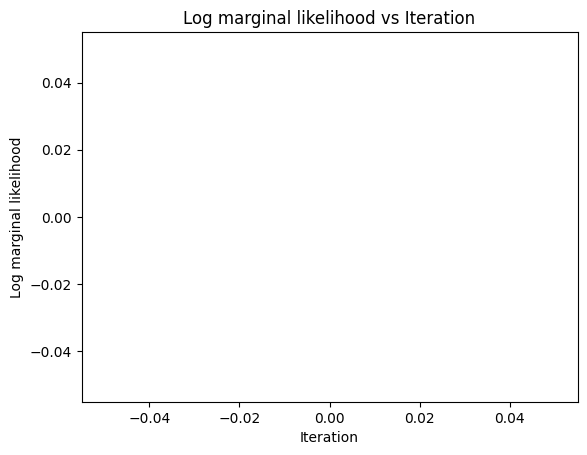

In [17]:
# plot log marginals
plt.plot(log_marginals,label='Estimated log marginal')
# plt.plot(true_logmarginal, label='True log marginal')
plt.xlabel('Iteration')
plt.ylabel('Log marginal likelihood')
plt.title('Log marginal likelihood vs Iteration')

In [18]:
# calculate log marginal over a grid of lengthscales and variances
# Create grid centered around true values, ensuring init values are included
lengthscale_min = min(init_kernel.lengthscale, true_length_scale - 0.1)
lengthscale_min = min(init_kernel.lengthscale, lengthscale_min)  # Ensure positive values
lengthscale_max = max(init_kernel.lengthscale, true_length_scale + 0.1)

variance_min = min(init_kernel.variance, true_variance - 2)
variance_min = max(0.1, variance_min)  # Ensure positive values
variance_max = max(init_kernel.variance, true_variance + 2)

lengthscales = torch.linspace(lengthscale_min, lengthscale_max, 50)
variances = torch.linspace(variance_min, variance_max, 50)
log_marginals_grid = torch.zeros((len(lengthscales), len(variances)))

# Calculate log marginal likelihood for each grid point
for i, lengthscale in enumerate(lengthscales):
    for j, variance in enumerate(variances):
        kernel = SquaredExponential(dimension=d, lengthscale=lengthscale.item(), variance=variance.item())
        log_marginals_grid[i, j] = kernel.log_marginal(x, y, sigmasq)

# lengthscales = torch.linspace(0.0001, 0.25, 50)
# variances = torch.linspace(0.1, 5, 50)
# log_marginals_grid = torch.zeros((len(lengthscales), len(variances)))
# for i, lengthscale in enumerate(lengthscales):
#     for j, variance in enumerate(variances):
#         kernel = SquaredExponential(dimension=1, lengthscale=lengthscale.item(), variance=variance.item())
#         log_marginals_grid[i, j] = kernel.log_marginal(x, y, sigmasq)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_76719/2016973872.py:53: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_76719/2016973872.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])


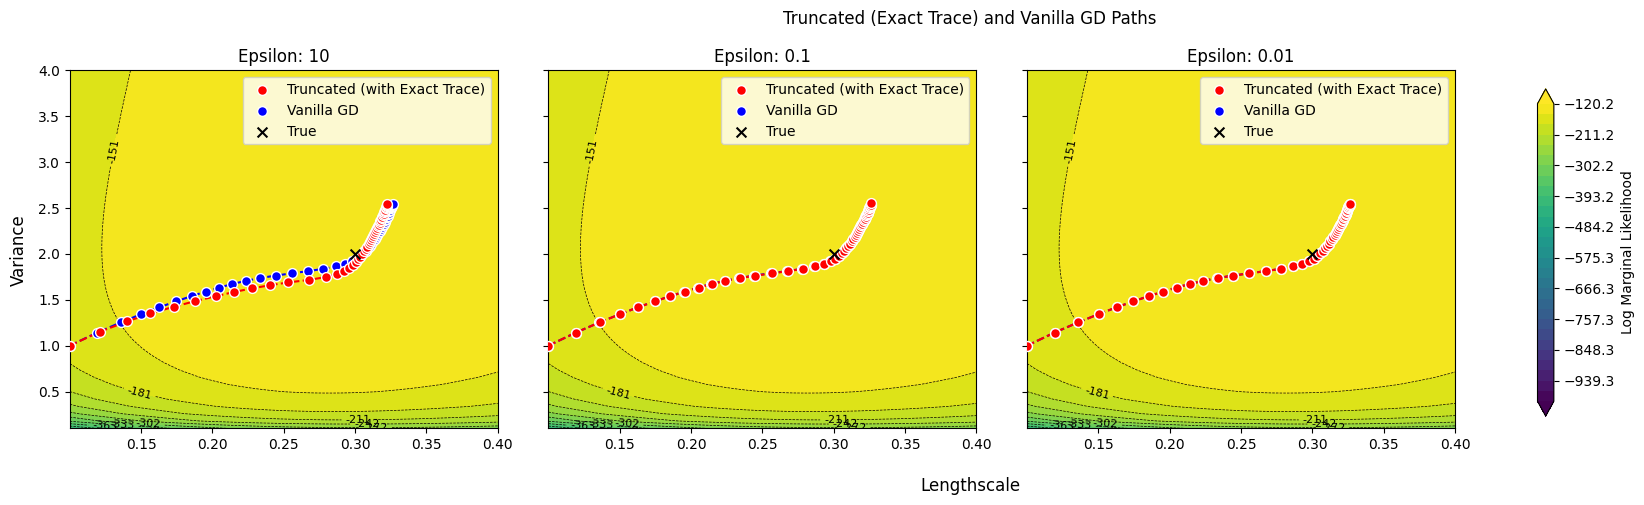

In [19]:

# For numerical stability, clip extremely low log marginal values.
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())
log_marginal_clipped = log_marginals_grid

# Set up detailed filled contour levels and slightly fewer levels for the line overlay.
fill_levels = np.linspace(-1000, log_marginals_grid.max(), 30)
line_levels = np.linspace(-1000, log_marginals_grid.max(), 30)

# Number of epsilon runs you have in results_exacttrace.
n_plots = len(results_exacttrace)

# Choose a layout: here we use 2 rows and as many columns as needed.
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))

# Convert vanilla SGD tracking lists to arrays.
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr  = np.array(tracked_variances_vanilla)

# Create a grid of subplots for visualization.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to a 1D list for easy iteration

# Iterate over each subplot (each corresponding to a different epsilon value)
for i, ax in enumerate(axes):
    if i < n_plots:
        # Retrieve the current epsilon run's results.
        res = results_exacttrace[i]
        tracked_lengthscales_path = np.array(res.get('tracked_lengthscales', []))
        tracked_variances_path   = np.array(res.get('tracked_variances', []))
        
        # Plot the filled contours of log marginal likelihood.
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay contour lines.
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')
        

        
        # Plot the results_exacttrace SGD path for the current epsilon:
        ax.scatter(tracked_lengthscales_path, tracked_variances_path,
                   color='red', edgecolors='w', s=50, label='Truncated (with Exact Trace)', zorder=11)
        ax.plot(tracked_lengthscales_path, tracked_variances_path,
                color='red', linestyle='--', zorder=10)
        # Plot the vanilla SGD path:
        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla GD', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        # plot an x at the true lengthscale and variance
        ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
        
        # Set a title that indicates the epsilon and trace_samples for this run.
        ax.set_title(f"Epsilon: {res['epsilon']}", fontsize=12)
        ax.legend(fontsize=10)
    else:
        # If there is no data to plot in this subplot, hide the axis.
        ax.axis('off')

# Add a colorbar to the entire figure using the last filled contour plot reference (cf).
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log Marginal Likelihood',
                    shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Label the common x and y axes.
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)

# Adjust layout to fit all subplots and the colorbar nicely.
plt.suptitle('Truncated (Exact Trace) and Vanilla GD Paths')

plt.tight_layout(rect=[.01, 0, 0.75, 1])
# plt.savefig('/Users/colecitrenbaum/Documents/GPs/Figures/vanilla_vs_truncated.png', dpi=300)
plt.show()


# make a figure first that shows that as epsilon goes to 0, then SGD is the same as the vanilla

# next a figure that compares stoch trace estimate w vanilla SGD

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_76719/169531153.py:54: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_76719/169531153.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar


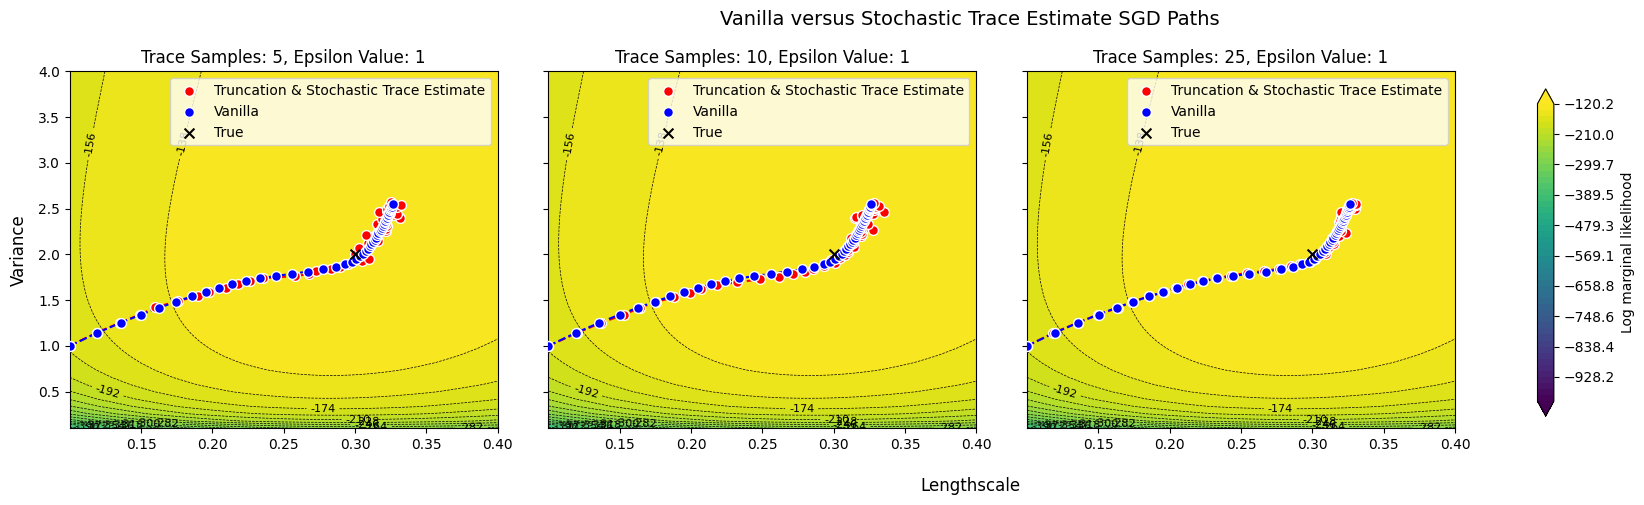

In [20]:

# Clip values below -100 to prevent extreme low outliers
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())
log_marginal_clipped = log_marginals_grid

# Set up filled contour levels (detailed)
# set fill and line levels based on the data

fill_levels = np.linspace(-1000, log_marginals_grid.max(), 50)
# Use fewer contour levels for the line overlay
line_levels = np.linspace(-1000, log_marginals_grid.max(), 50)

# Determine subplot grid dimensions for 2 rows
n_plots = len(results)
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr = np.array(tracked_variances_vanilla)
# Create a grid of subplots with 2 rows and the required number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
# Plot each result in its respective subplot
for i, ax in enumerate(axes):
    # if i < n_plots:  # Only plot if there's data for this subplot
    #     tracked_lengthscales_truncated_arr = tracked_lengthscales_truncated
    #     tracked_variances_truncated_arr = tracked_variances_truncated
    if i < n_plots:  # Only plot if there's data for this subplot
        # Plot filled contours
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay a reduced number of contour lines for clarity
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')

        # Overlay tracked hyperparameter points for the current result
        # Ensure tracked_lengthscales and tracked_variances are properly populated
        tracked_lengthscales_arr = np.array(results[i].get('tracked_lengthscales', []))
        tracked_variances_arr = np.array(results[i].get('tracked_variances', []))
        ax.scatter(tracked_lengthscales_arr, tracked_variances_arr,
                   color='red', edgecolors='w', s=50, label='Truncation & Stochastic Trace Estimate', zorder=10)
        ax.plot(tracked_lengthscales_arr, tracked_variances_arr,
                color='red', linestyle='--', zorder=9)
        # overlay vanilla tracked points

        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        #overlay truncated tracked points

        # ax.scatter(tracked_lengthscales_truncated_arr, tracked_variances_truncated_arr,
        #            color='green', edgecolors='w', s=50, label='Tracked points (Truncated)', zorder=10)
        # Set title for each subplot
        ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)

        ax.set_title(f"Trace Samples: {results[i]['trace_samples']}, Epsilon Value: {results[i]['epsilon']}", fontsize=12)
        
        # add legend
        ax.legend(fontsize=10)

    else:
        # If no data is available for this subplot, turn the axis off.
        ax.axis('off')

# Add a colorbar to the figure, placed outside the subplots
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log marginal likelihood', shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)
# Label the shared axes
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)
plt.suptitle('Vanilla versus Stochastic Trace Estimate SGD Paths', fontsize=14)
plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar
plt.savefig('/Users/colecitrenbaum/Documents/GPs/Figures/vanilla_vs_sgd.png', dpi=300)
plt.show()

# save a high res version of the plot


$$\alpha = (K+\sigma^2 I)^{-1}y$$

$$\frac{\partial (K + \sigma^2 I)}{\partial \theta} = FD'F^* + \frac{\partial (\sigma^2 I)}{\partial \theta}$$
where 
$$D'_{jj} = h^d\frac{\partial }{\partial \theta} \hat{k}_\theta(\xi_j)